# 강화학습과 최적제어 Part 1
공정시스템 여름학교 Module C: 공정시스템을 위한 인공지능

Session 1-2: 강화학습과 최적제어

2025년 8월 20일 (수) 13:30 - 17:30

인천대학교 에너지화학공학과 김종우

In [14]:
!python -m pip install --upgrade pip
!python -m pip install "numpy<2" scipy matplotlib
!python -m pip install casadi==3.6.5
!python -m pip install opencv-python moviepy>=1.0.3 imageio imageio-ffmpeg mediapy
!python -m pip install gymnasium[toytext] pygame
!python -m pip install torch

# 1. Pytorch로 Neural Networks 생성, 훈련

다음 코드를 통해 fully connected neural networks를 생성할 수 있다. 여기서 네트워크의 구조는 다음과 같다.
\begin{equation*}
\begin{split}
    Input &\rightarrow fc1 \rightarrow bn1 \rightarrow leaky\ relu \\
          &\rightarrow fc2 \rightarrow bn2 \rightarrow leaky\ relu \\
          &\rightarrow fc3 \rightarrow bn3 \rightarrow leaky\ relu \\
          &\rightarrow fc4 \rightarrow Output
\end{split}
\end{equation*}

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetworks(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(NeuralNetworks, self).__init__()

        self.h_nodes = hidden_dims

        self.fc1 = nn.Linear(input_dim, self.h_nodes[0])
        self.bn1 = nn.LayerNorm(self.h_nodes[0])
        self.fc2 = nn.Linear(self.h_nodes[0], self.h_nodes[1])
        self.bn2 = nn.LayerNorm(self.h_nodes[1])
        self.fc3 = nn.Linear(self.h_nodes[1], self.h_nodes[2])
        self.bn3 = nn.LayerNorm(self.h_nodes[2])
        self.fc4 = nn.Linear(self.h_nodes[2], output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

네트워크를 다음과 같이 불러올수 있다.

In [16]:
import torch
nets = NeuralNetworks(2, 2, [16, 16, 8])
x = torch.rand([8, 2]) # 8개의 (2, 1) 데이터를 생성
print(nets(x))
print(nets(x).shape) # 8개의 (2, 1) 데이터를 반환
print(nets(x).detach().numpy()) # 결과값을 그래프에서 detach 한 후 numpy 형태로 반환

tensor([[-0.4358,  0.7688],
        [-0.4237,  0.7843],
        [-0.4108,  0.7908],
        [-0.4247,  0.7819],
        [-0.4222,  0.7509],
        [-0.4299,  0.7898],
        [-0.4450,  0.7111],
        [-0.4361,  0.7487]], grad_fn=<AddmmBackward0>)
torch.Size([8, 2])
[[-0.43575755  0.7688297 ]
 [-0.42372072  0.78426784]
 [-0.41084838  0.79080546]
 [-0.42469674  0.7818742 ]
 [-0.42221242  0.7508595 ]
 [-0.42993423  0.7897591 ]
 [-0.444982    0.71105933]
 [-0.43608275  0.7487235 ]]


$y=2x_1 + 2x_2$ 함수를 Neural net으로 훈련하기 위해 8개의 입출력 데이터를 생성한다. 네트워크를 train하기위해 mean-squared error loss function을 정의한다.

In [17]:
import torch
import torch.nn.functional as F
nets = NeuralNetworks(2, 2, [16, 16, 8])

x = torch.rand([8, 2]) # 8개의 (2, 1) 입력 데이터를 생성
pred = nets(x)
target = (2 * x).clone().detach() # 예측해야 하는 데이터를 생성
cost = F.mse_loss(pred, target)
print(cost)

tensor(0.8664, grad_fn=<MseLossBackward0>)


Neural networks를 train하기 위해 경사하강법을 사용한다. 경사하강법은 loss function $L$의 parameter $W$에 대한 미분, $\dfrac{\partial L}{\partial W}$를 사용한다. `backward()` 함수를 이용하여 미분을 계산하고 `step()` 함수를 이용하여 parameter를 업데이트하는 과정을 수행한다.

In [18]:
import torch
import torch.nn.functional as F
nets = NeuralNetworks(2, 2, [16, 16, 8])

x = torch.rand([8, 2]) # 8개의 (2, 1) 입력 데이터를 생성
pred = nets(x)
target = (2 * x).clone().detach() # 예측해야 하는 데이터를 생성
cost = F.mse_loss(pred, target)

# optimizer 설정. 경사 하강법 SGD을 사용. lr은 learning rate를 의미
optimizer = torch.optim.SGD(nets.parameters(), lr=0.01)
# optimizer 설정. 경사 하강법 Adam을 사용
# optimizer = torch.optim.Adam(nets.parameters(), lr=0.01, eps=1E-4, weight_decay=1E-3)

# gradient를 0으로 초기화
optimizer.zero_grad()
# 비용 함수를 미분하여 gradient 계산
cost.backward() # backward 연산
# W와 b를 업데이트
optimizer.step()

`train()` 모드에서는 neural networks를 train한다. 훈련된 neural networks를 실제 사용하기 위해 `test()` 모드를 사용한다.

In [19]:
import torch
import torch.nn.functional as F

nets = NeuralNetworks(2, 2, [16, 16, 8])
# optimizer 설정. 경사 하강법 SGD을 사용. lr은 learning rate를 의미
optimizer = torch.optim.SGD(nets.parameters(), lr=0.01, weight_decay=1E-3)
# optimizer = torch.optim.SGD(nets.parameters(), lr=0.01, eps=1E-4, weight_decay=1E-3)

# optimizer 설정. 경사 하강법 Adam을 사용
# optimizer = torch.optim.Adam(nets.parameters(), lr=0.01, eps=1E-4, weight_decay=1E-3)

# train mode에서는 train()을 사용
nets.train()
n_epoch = 201
for epoch in range(n_epoch):
  x = torch.rand([8, 2])
  pred = nets(x)
  target = (2*x).clone().detach() # 예측해야 하는 데이터를 생성
  cost = F.mse_loss(pred, target)

  # gradient를 0으로 초기화
  optimizer.zero_grad()
  # 비용 함수를 미분하여 gradient 계산
  cost.backward() # backward 연산
  # W와 b를 업데이트
  optimizer.step()
  # 20회에 한번 출력
  if epoch % 20 == 0:
    print(target.shape)
    print(f'Epoch {epoch:4d}/{n_epoch} Cost: {cost.item():.4f}')

# test mode에서는 eval()을 사용
nets.eval()
with torch.no_grad():
  x = torch.rand([1, 2])
  test = nets(x)
  print(2*x, test)

torch.Size([8, 2])
Epoch    0/201 Cost: 0.8186
torch.Size([8, 2])
Epoch   20/201 Cost: 0.2713
torch.Size([8, 2])
Epoch   40/201 Cost: 0.0716
torch.Size([8, 2])
Epoch   60/201 Cost: 0.0693
torch.Size([8, 2])
Epoch   80/201 Cost: 0.0585
torch.Size([8, 2])
Epoch  100/201 Cost: 0.0474
torch.Size([8, 2])
Epoch  120/201 Cost: 0.0437
torch.Size([8, 2])
Epoch  140/201 Cost: 0.0294
torch.Size([8, 2])
Epoch  160/201 Cost: 0.0084
torch.Size([8, 2])
Epoch  180/201 Cost: 0.0092
torch.Size([8, 2])
Epoch  200/201 Cost: 0.0185
tensor([[1.9305, 0.3775]]) tensor([[1.6868, 0.5231]])


# 2. Gym environment를 이용한 강화학습 구현

OpenAi의 Gymnasium package는 강화학습 알고리즘을 테스트해볼수 있는 여러가지 Benchmark environment가 있다. 보드게임, 고전게임, 기계시스템 제어 등 화공제어와는 관련이 적지만 강화학습 학습에 많이 사용된다. 사용에 필요한 package import, 버젼확인 및 설정을 다음과 같이 한다.

In [20]:
import cv2,time,psutil,random
import gymnasium as gym
from gymnasium import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media
import torch
import torch.nn as nn
import torch.nn.functional as F

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
plt.rc('xtick',labelsize=8); plt.rc('ytick',labelsize=8)
print ("gym:[%s]"%(gym.__version__))
print ("numpy:[%s]"%(np.__version__))
print ("matplotlib:[%s]"%(matplotlib.__version__))
print ("Pytorch:[%s]"%(torch.__version__))

gym:[1.2.0]
numpy:[1.23.5]
matplotlib:[3.10.5]
Pytorch:[2.8.0+cu128]


Frozen Lake environment는 시작지점에서 목표지점으로 가는 경로를 찾는 미로문제이다. 각 칸마다 상하좌우로 움직일수 있고, 얼지않은 지점 (hole)에 빠지면 실패한다. 바닥이 미끄러워 의도한 방향으로 움직일 확률이 1/3이다. 8x8은 미로의 크기를 뜻한다. `gym.make()`를 통해 environment를 불러올수 있다.

In [21]:
env = gym.make('FrozenLake8x8-v1',render_mode='rgb_array')
print ("[%s] initialized."%(env.unwrapped.spec.id))

[FrozenLake8x8-v1] initialized.


`env.render()`함수를 통해 FrozenLake environment를 그릴수 있다.

In [22]:
def plot_env(env,figsize=(4,4),title_str=None,title_fs=10,
             PLOT_IMG=True,RETURN_IMG=False):
    img = env.render()
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title_str is not None:
        plt.title(title_str,fontsize=title_fs)
    if PLOT_IMG:
        plt.show()
    # (Optional) Get image
    if RETURN_IMG:
        # Use fig.canvas.buffer_rgba() to get the image data
        fig.canvas.draw()
        # Convert RGBA to RGB
        img_buffer = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close(fig) # Close the figure to free up memory
        return img_buffer

def visualize_matrix(M,strs='',figsize=(4,4),fontsize=15,
                     cmap='turbo',title='Title',title_fs=15,REMOVE_TICK_LABELS=True,
                     PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize a matrix colors and strings
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]

    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs)
    fig.tight_layout()
    fig.subplots_adjust(top=1.05)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        img = mplfig_to_npimage(fig)
        plt.close()
        return img

print ("Ready.")

Ready.


/home/sjbaek/miniforge3/envs/PSE_env/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


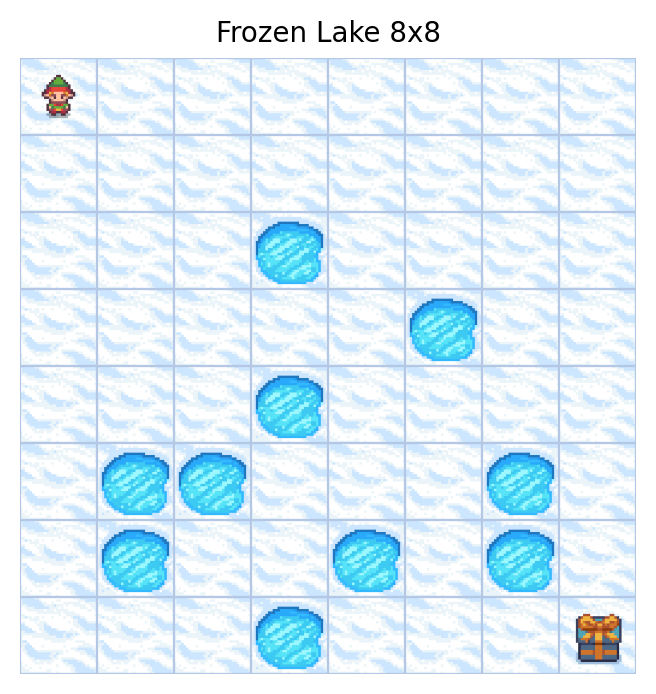

In [23]:
env.reset()
plot_env(env,figsize=(4,4),title_str='Frozen Lake 8x8',title_fs=10)

State와 observation state의 갯수는 $8\times 8 = 64$개이다. Action space는 상하좌우 이동으로 $4$의 크기를 가지고 있다.

In [24]:
obs_space    = env.observation_space
n_state      = obs_space.n
action_space = env.action_space
n_action     = action_space.n
print("State space:[%d]"%(n_state))
print("Action space:[%d]"%(n_action))

State space:[64]
Action space:[4]


`env.action_space.sample()`을 통해 random action을 생성하여 simulation 해볼수 있다. `env.step(action)`함수는 `action`이 주어졌을때 다음 step의 `observation`, `reward`, `done`, `truncated`, `info` 정보를 불러온다. 최대 `n_step=100`회까지 움직이고, 웅덩이에 빠지거나 goal state에 도달하면 `done=1`이 되면서 episode가 종료된다.

In [25]:
env.reset()
n_step = 100
frames = []
for tick in range(n_step):
    action = env.action_space.sample()
    observation, reward, done, truncated, info = env.step(action) # step
    title_str = "tick:[%d/%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,n_step,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    if done: break
env.close()
print ("Done (tick:[%d])."%(tick))

Done (tick:[29]).


In [26]:
media.show_video(frames, fps=5)

모든 state와 action에 대해 State transition probability $P(s'|s, a)$와 reward $r(s, a)$를 확인할 수 있다.

Action 방향과 그 좌우로 움직일 확률이 1/3이고, 한번에 1칸만 움직일수 있는것을 확인할 수 있다.

Goal state (s=63)에 도달할때 reward가 0이고 그 이외에는 reward가 0이다.

In [ ]:
P = env.unwrapped.P #P는 64 x 64 x 4
for s in P.keys(): # for all states
    for a in P[s].keys(): # for all actions
        for (prob,s_prime,rwd,_) in P[s][a]:
            print ("P(s':%02d|s:%02d,a:%02d)=%.2f, Reward=%.2f"%
                   (s_prime,s,a,prob,rwd)) # 각 action의 확률이 1/3인 이유: 미끄러워서 일부러 모두 같은 확률로 설정함 (게임 규칙칙)

P(s':00|s:00,a:00)=0.33, Reward=0.00
P(s':00|s:00,a:00)=0.33, Reward=0.00
P(s':08|s:00,a:00)=0.33, Reward=0.00
P(s':00|s:00,a:01)=0.33, Reward=0.00
P(s':08|s:00,a:01)=0.33, Reward=0.00
P(s':01|s:00,a:01)=0.33, Reward=0.00
P(s':08|s:00,a:02)=0.33, Reward=0.00
P(s':01|s:00,a:02)=0.33, Reward=0.00
P(s':00|s:00,a:02)=0.33, Reward=0.00
P(s':01|s:00,a:03)=0.33, Reward=0.00
P(s':00|s:00,a:03)=0.33, Reward=0.00
P(s':00|s:00,a:03)=0.33, Reward=0.00
P(s':01|s:01,a:00)=0.33, Reward=0.00
P(s':00|s:01,a:00)=0.33, Reward=0.00
P(s':09|s:01,a:00)=0.33, Reward=0.00
P(s':00|s:01,a:01)=0.33, Reward=0.00
P(s':09|s:01,a:01)=0.33, Reward=0.00
P(s':02|s:01,a:01)=0.33, Reward=0.00
P(s':09|s:01,a:02)=0.33, Reward=0.00
P(s':02|s:01,a:02)=0.33, Reward=0.00
P(s':01|s:01,a:02)=0.33, Reward=0.00
P(s':02|s:01,a:03)=0.33, Reward=0.00
P(s':01|s:01,a:03)=0.33, Reward=0.00
P(s':00|s:01,a:03)=0.33, Reward=0.00
P(s':02|s:02,a:00)=0.33, Reward=0.00
P(s':01|s:02,a:00)=0.33, Reward=0.00
P(s':10|s:02,a:00)=0.33, Reward=0.00
P

Value iteration 수행

Optimal value function은 다음 Bellman optimality equation을 만족한다.
\begin{equation}
V^*(s) = \max_a \sum_{s'}
\left[
r(s,a,s') + \gamma V^*(s')
\right]
P(s'|s,a)
\end{equation}

이를 만족하는 $V^*(s)$를 찾기 위해 다음의 iteration을 수행한다.

- 초기화: $V_0(s) = \mathrm{random}$
- Loop
    - For all states $s$
        - For all actions $a$
            - For all next states $s'$
                - $ Q_k(s,a)\leftarrow Q_k(s,a) + \sum_{s'}\left[ r(s,a,s') + \gamma V_k(s') \right] P(s'|s,a)$
        - $V_{k+1}(s) = \max_{a'} Q_k(s,a')$
    - If: $\|V_{k+1} - V_k\|_{\infty} \le \epsilon$ stop

In [ ]:
def value_iteration(env,gamma=0.99,eps=1e-6):
    # Extract the world information
    n_state = env.observation_space.n
    n_action = env.action_space.n
    # Transition probability
    P = env.unwrapped.P
    # Initialize value
    V = np.random.uniform(size=(n_state,1)) # [n_state x 1], 초기화기화
    # Loop
    tick,V_dists,V_list,Q_list = 0,[],[],[]
    while True:
        tick = tick + 1
        Q = np.zeros(shape=(n_state,n_action)) # [n_state x n_action]
        for s in P.keys(): # for all states s
            for a in P[s].keys(): # for all actions a
                for prob, s_prime, reward, done in P[s][a]:
                    Q[s,a] += (reward + gamma*V[s_prime])*prob
        V_prime = np.max(Q,axis=1) # [n_state x 1]
        V_dist = np.max(np.abs(V-V_prime))
        V_dists.append(V_dist)
        V = V_prime # update
        V_list.append(V)
        Q_list.append(Q)
        if V_dist < eps:
            break
    return Q,V,V_dists,V_list,Q_list

Discount factor $\gamma=0.99$로 하여 value iteration을 수행한다.

$\gamma$는 무한급수 $\sum_{t=0}^{\infty}\gamma^t r(s_t, a_t)$의 수렴을 위한 역할도 하고, 먼 미래의 reward를 현재 가치로 환산하는 역할도 한다.

In [29]:
start = time.time()
Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=0.99,eps=1e-6)
print("It took [%.2f]s."%(time.time()-start))
print ("Value Iteraction converged in [%d] loops."%(len(V_dists)))

It took [0.20]s.
Value Iteraction converged in [910] loops.


Optimal policy를 그린다.

Optimal policy는 다음과 같이 정의된다 $\pi(a|s) = 1$ for $a=\mathrm{arg}\max_{\pi}V^{\pi}(s)$

이는 코드에서 `Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1` 로 표현되었다.

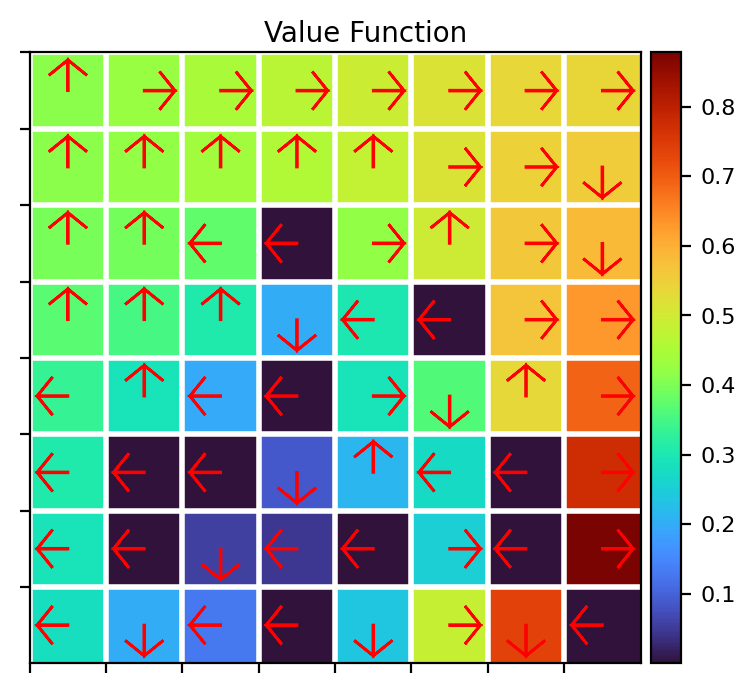

In [30]:
def plot_pi_v(Pi,V,figsize=(4,4),title='Value Function',cmap='turbo',title_fs=15,
              subplots_top=1.0,REMOVE_TICK_LABELS=True,
              PLOT_IMG=True,RETURN_IMG=False):
    """
    Visualize pi and V
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = V.shape[0],V.shape[1]
    fig,ax = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax)
    im = ax.imshow(V,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0))
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0: plt.arrow(j+0.5,i+0.5,-arr_len,0,
                          color="r",alpha=Pi[s][0],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0: plt.arrow(j+0.5,i+0.5,0,arr_len,
                          color="r",alpha=Pi[s][1],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0: plt.arrow(j+0.5,i+0.5,arr_len,0,
                          color="r",alpha=Pi[s][2],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0: plt.arrow(j+0.5,i+0.5,0,-arr_len,
                          color="r",alpha=Pi[s][3],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs)
    fig.tight_layout()
    fig.subplots_adjust(top=subplots_top)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    if PLOT_IMG:
        plt.show()
    if RETURN_IMG:
        # Use fig.canvas.buffer_rgba() to get the image data
        fig.canvas.draw()
        # Convert RGBA to RGB
        img_buffer = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close()
        return img_buffer


Pi = np.zeros((n_state,n_action))
Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
plot_pi_v(Pi=Pi,V=np.reshape(V,(8,8)),figsize=(4,4),title_fs=10,subplots_top=1.05)

Value function의 수렴성 (이전 iteration대비 value function이 바뀐 정도)를 다음과 같이 나타낸다.

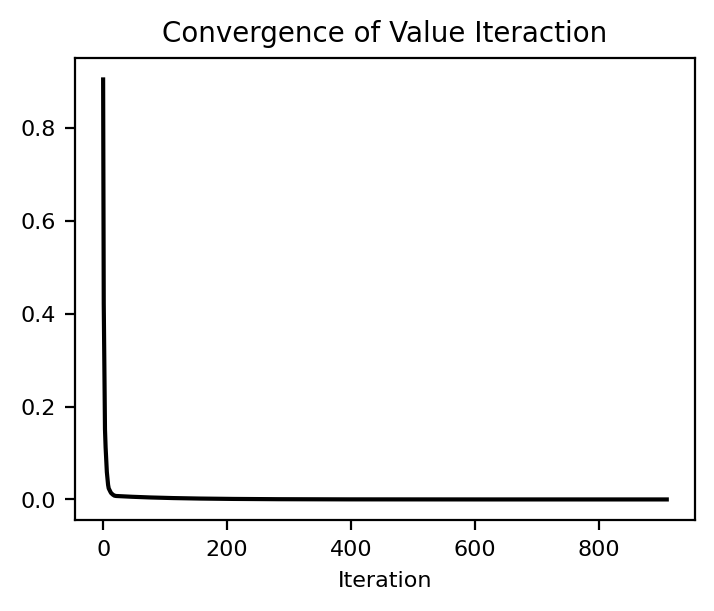

In [31]:
plt.figure(figsize=(4,3))
plt.plot(V_dists,'k-')
plt.xlabel('Iteration',fontsize=8)
plt.title("Convergence of Value Iteraction",fontsize=10)
plt.show()

In [32]:
n_plot = 50
frames = []
for itr in np.round(np.linspace(0,len(Q_list)-1,n_plot)).astype(np.int32):
    V,Q = V_list[itr],Q_list[itr]
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    img = plot_pi_v(
        Pi,np.reshape(V,(8,8)),title="Value Function@iter=%d"%(itr),title_fs=10,
        PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
media.show_video(frames, fps=5)
print ("Done.")

Done.


Value iteration에서 구한 optimal policy를 따라 simulation한다.

In [33]:
# Solve value iteration
gamma = 0.99
Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=gamma,eps=1e-8)
Pi = np.zeros((n_state,n_action))
Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
obs,_ = env.reset() # reset env
ret,frames = 0,[]
for tick in range(1000):
    action = np.random.choice(n_action,1,p=Pi[obs][:])[0] # select action
    next_obs,reward,done,truncated,info = env.step(action)
    # Render
    title_str = "tick:[%d] action:[%s] reward:[%.2f] done:[%d]"%(
        tick,action,reward,done
    )
    img = plot_env(env,figsize=(4,4),title_str=title_str,title_fs=8,
                   PLOT_IMG=False,RETURN_IMG=True)
    frames.append(img)
    obs = next_obs
    ret = reward + gamma*ret
    if done: break
env.close()
print ("Return is [%.3f] (tick:[%d])"%(ret,tick))

Return is [1.000] (tick:[66])


In [34]:
media.show_video(frames, fps=5)